# Actividad 2

En esta práctica se nos pide usar los datos del dataset MNIST `tf.keras.datasets.mnist.load_data()`. y entrenar redes neuronalos con 3 y 4 capas ocultas. Nuestro objetico es alzancar 98% de exactitud ajustando los hiperparametros.


## 1 Datos y paquetes necesarios

Empecemos cargando los paquetes necesarios

In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

Carguemos también los datos. Los divididiremos en conjunto de entrenamiennto y de pruebas.

In [2]:
(X_train_full, y_train_full), (X_test, y_test) = tf.keras.datasets.mnist.load_data()

El conjunto de datos MNIST  contiene imagenes en escalade grises de 28,28 pixeles. Nuestro conjunto de entrenamiento contiene 60.000 de ellas.

In [3]:
X_train_full.shape

(60000, 28, 28)

Cada pixel de la imagen se almacena en un byte (valor de 0 a 255):

In [4]:
X_train_full.dtype

dtype('uint8')

Vamos a dividir el conjunto de entrenamiento en dos conjuntos: entrenamiento y validación. Usaremos los datos de validación para comparar los modelos. También transformamos los valores de la intensidad de la imagen para que sean valores entre 0 y 1. Lo hacemos transformandolos en float y dividiendo por 255.

In [5]:
X_valid, X_train = X_train_full[:5000] / 255., X_train_full[5000:] / 255.
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]
X_test = X_test / 255.

Vamos a mostrar una de las imagenes para comprobar que el proceso haya ido bien:

Usamos la función `imshow()` de  Matplotlib con un mapa de color binario.

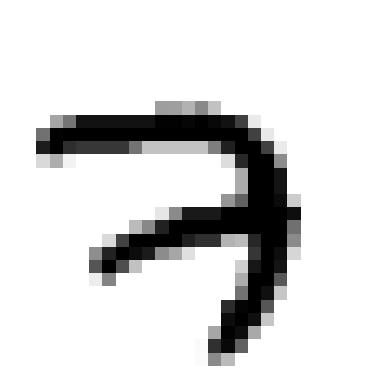

In [7]:
plt.imshow(X_train[0], cmap="binary")
plt.axis('off')
plt.show()

Las etiquetas son los IDs de las clases, de 0 a 9. Convenientemente, los IDs de clase se corresponden con los ddígitos de las imágenes por tanto no necesitamos un array `class_names`

In [7]:
y_train

array([7, 3, 4, ..., 5, 6, 8], dtype=uint8)

El conjunto de validación contiene 5,000 imagenes, y el conjunto de pruebas 10,000:

In [8]:
X_valid.shape

(5000, 28, 28)

In [9]:
X_test.shape

(10000, 28, 28)

Vamos a mostrar otras cuantas imágenes para asegurarnos de que no ha habido errores.

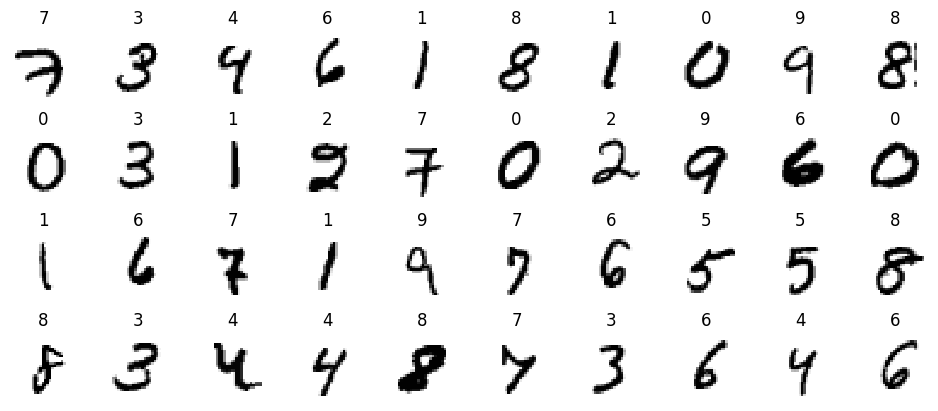

In [10]:
n_rows = 4
n_cols = 10
plt.figure(figsize=(n_cols * 1.2, n_rows * 1.2))
for row in range(n_rows):
    for col in range(n_cols):
        index = n_cols * row + col
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(X_train[index], cmap="binary", interpolation="nearest")
        plt.axis('off')
        plt.title(y_train[index])
plt.subplots_adjust(wspace=0.2, hspace=0.5)
plt.show()

## 2 Calculando el learning rate de Github

En el ejercicio se nos pide usar el learning rate de GitHub. Vamos a repetir aquí como se calculó ese learning rate.

Primero construimos un callback que incrementa el learning rate a cada iteración. En cada iteración también guarda el learning rate y el error para poder construir un gráfico más tarde.

In [48]:
K = tf.keras.backend

class ExponentialLearningRate(tf.keras.callbacks.Callback):
    def __init__(self, factor):
        self.factor = factor
        self.rates = []
        self.losses = []

    def on_batch_end(self, batch, logs=None):
        lr = self.model.optimizer.learning_rate.numpy() * self.factor
        self.model.optimizer.learning_rate = lr
        self.rates.append(lr)
        self.losses.append(logs["loss"])

    def reset(self):
        self.rates = []
        self.losses = []

Vamos a fijar las semillas aleatorias para que los resultados sean replicables.

In [12]:
tf.keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

Se construye usando la API secuencial un modelo con dos capas ocultas, la primera de 300 neuronas y la segunda de 100, las dos con activación relu. La última capa es una de 10 neuronas con la función de activación softmax. Esto es debido a que estamos en un problema de clasificación con 10 clases.

In [13]:
model = tf.keras.Sequential([
    tf.keras.Input(shape=(28, 28)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(300, activation="relu"),
    tf.keras.layers.Dense(100, activation="relu"),
    tf.keras.layers.Dense(10, activation="softmax")
])

Empezamos con un learning rate de 1e-3, y lo aumentamos 0.5% en cada iteración:

In [14]:
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-3)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])
expon_lr = ExponentialLearningRate(factor=1.005)

Entrenamos el modelo 1 época:

In [15]:
history = model.fit(X_train, y_train, epochs=1,
                    validation_data=(X_valid, y_valid),
                    callbacks=[expon_lr])

1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.5162 - loss: nan - val_accuracy: 0.0958 - val_loss: nan


Ahora construimos una gráfica del error en función del learning rate:

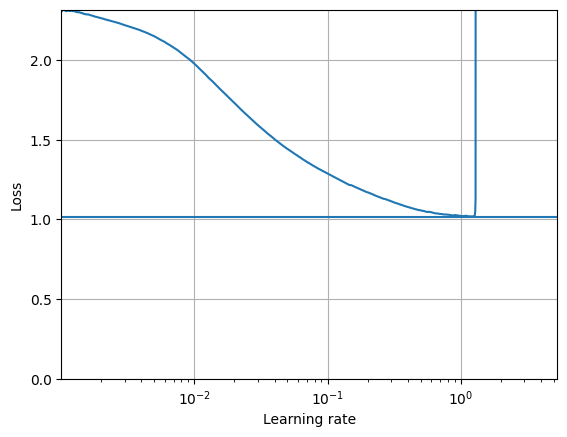

In [16]:
plt.plot(expon_lr.rates, expon_lr.losses)
plt.gca().set_xscale('log')
plt.hlines(min(expon_lr.losses), min(expon_lr.rates), max(expon_lr.rates))
plt.axis([min(expon_lr.rates), max(expon_lr.rates), 0, expon_lr.losses[0]])
plt.grid()
plt.xlabel("Learning rate")
plt.ylabel("Loss")
plt.show()

La pérdida alcanza un mínimo cuando el learning rate es 6e-1, así que probamos con la mitad, 3e-1:

In [17]:
tf.keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [18]:
model = tf.keras.Sequential([
    tf.keras.Input(shape=(28, 28)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(300, activation="relu"),
    tf.keras.layers.Dense(100, activation="relu"),
    tf.keras.layers.Dense(10, activation="softmax")
])

Hemos limpiado la sesión y reconstruido el modelo porque tensorflow guarda datos de todos los modelos construidos anteriormente. Si no limpiamos la sesión, cada vez nos irá más lento.

Seleccionamos nuestro optimizador y usamos el learning rate anterior. Cambiamos la forma de compilar el modelo para que use nuestro optimizador presonalizado.

In [19]:
optimizer = tf.keras.optimizers.SGD(learning_rate=3e-1)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])

Creamos una carpeta donde vamos a guardar los datos para visualizar las curvas de aprendizaje.

In [11]:
from pathlib import Path

run_index = 1
run_logdir = Path() / "my_mnist_logs" / "run_{:03d}".format(run_index)
run_logdir

WindowsPath('my_mnist_logs/run_001')

Entrenamos el modelo:

    - Usamos early stopping para que detenga el entrenamiento si no hay progreso significativo
    - Usamos Model Checkpoint para guardar el mejor modelo encontrado en el entrenamiento.
    - Usamos tensorboard para almacenar los datos que más tarde visualizaremos

In [21]:
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=20)
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("my_mnist_model.keras", save_best_only=True)
tensorboard_cb = tf.keras.callbacks.TensorBoard(run_logdir)

history = model.fit(X_train, y_train, epochs=100,
                    validation_data=(X_valid, y_valid),
                    callbacks=[checkpoint_cb, early_stopping_cb, tensorboard_cb])

Epoch 1/100
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8690 - loss: 0.4078 - val_accuracy: 0.9688 - val_loss: 0.1002
Epoch 2/100
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9704 - loss: 0.0996 - val_accuracy: 0.9750 - val_loss: 0.0860
Epoch 3/100
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9826 - loss: 0.0604 - val_accuracy: 0.9784 - val_loss: 0.0824
Epoch 4/100
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.9872 - loss: 0.0417 - val_accuracy: 0.9756 - val_loss: 0.0961
Epoch 5/100
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9900 - loss: 0.0327 - val_accuracy: 0.9770 - val_loss: 0.0861
Epoch 6/100
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9916 - loss: 0.0253 - val_accuracy: 0.9750 - val_loss: 0.1090
Epoch 7/100
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.9932 - loss: 0.0216 - val_accuracy: 0.9746 - val_loss: 0.1044
Epoch 8/100
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9917 - loss: 0

Cargamos el mejor modelo encontrado arriba y lo evaluamos. Vemos que alcanzamos una exactitud muy alta.

In [22]:
model = tf.keras.models.load_model("my_mnist_model.keras")
model.evaluate(X_test, y_test)

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 854us/step - accuracy: 0.9731 - loss: 0.0919


[0.0739976167678833, 0.9787999987602234]

Echemos un ojo a las curvas de aprendizaje con tensorboard.

In [25]:
%load_ext tensorboard
%tensorboard --logdir=./my_mnist_logs/run_001

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6010 (pid 23976), started 0:00:04 ago. (Use '!kill 23976' to kill it.)

Limpiamos la sesión de tensorboard y volvemos a elegir la semilla aleatoria.

In [24]:
tf.keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

## 3 Modelos de 3 y 4 capas ocultas

Vamos a empezar ahora con lo que realmente pride la práctica. Queremos construir modelos con 3 y 4 capas ocultas, de momento usando el learning rate que hemos calculado arriba. Se nos pide probar diferentes números de neuronas por capa y quedarnos con el mejor modelo usando early stopping.

En la práctica se nos pide que comparemos dos modelos de 3 capas y dos modelos de 4 capas. Puesto que no es muy computacionalmente intensivo entrenar estos modelos, he decidido probar 4 de cada arquitectura. En ambos casos son modelos con el mismo número de neuronas por capa. Esta decisión está basada en los consejos del libro, que nos dicen que actualmente la práctica más común es entrenar modelos con un número de neuronas por capa uniforme (y suficientemente grande) y usar regularización y early stopping para que no sobreajuste.



### Modelo de 3 capas.

Comencemos con los de 3 capas. Vamos a construit modelos de 3 capas de  250, 300, 350 y 400 neuronas. Para cada uno de los modelos, comenzamos limpiando la sesión e inicializando las semillas aleatorias. Puesto que no estamos entrenando demasiados modelos no es estrictamente necesario hacer esto antes de entrenar cada modelo, pero ayuda puesto que TensorFlow almacena los datos de los modelos y sus grafos de computación en una sesión global. En cada interación del bucle creamos una carpeta donde guardar los datos para visualizar luego con tensorboard y guardamos el mejor modelo y los resultados.

El código de la siguente celda hace lo siguiente:

    - Elegimos un array de posibles tamaños de las capas, en este caso, 250, 300, 350 0 400.
    - Para cada uno de los tamaños entrenamos un modelo de tres capas ocultas usando early stopping, model checkpoint y tensorboard, además guardamos los datos del modelo en un diccionario.
    - Una vez hemos probado todos los modelos extraemos el modelo con los mejores resultados usando los datos del diccionario. 

In [25]:
from itertools import product

#Seleccionamos el optimizer y especificamos el callback para early_stopping puesto que será uniforme para cada iteración.
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=20)


# Posible número de neuronas
hidden_layer_sizes = [250, 300, 350, 400] 

# Diccionario donde almacenamos los resultados
results = []

# Para todas las posibles combinaciones
for h in hidden_layer_sizes:

    # Limpiamos la sesión y volvemos a seleccionar las semillas y el optimizador 
    tf.keras.backend.clear_session()
    np.random.seed(42)
    tf.random.set_seed(42)
    optimizer = tf.keras.optimizers.SGD(learning_rate=3e-1)

    print(f"Entrenando modelo con {h} neuronas por capa")

        # Creamos un directorio para almacenar los datos del modelo
    unique_run_logdir = Path() / "my_mnist_logs_3L" / f"3L_{h}"
    unique_run_logdir.mkdir(parents=True, exist_ok=True)
    tensorboard_cb = tf.keras.callbacks.TensorBoard(str(unique_run_logdir))

    checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
    f"Best_model_3L_{h}.keras", save_best_only=True
)
    
    # Creamos el modelo
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(28, 28)),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(h, activation="relu"),
        tf.keras.layers.Dense(h, activation="relu"),
        tf.keras.layers.Dense(h, activation="relu"),
        tf.keras.layers.Dense(10, activation="softmax")
    ])
    
    model.compile(optimizer=optimizer,
                  loss="sparse_categorical_crossentropy",
                  metrics=["accuracy"])
    
    # Entrenamos el modelo
    history = model.fit(
        X_train, y_train,
        epochs=100,
        validation_data=(X_valid, y_valid),
        callbacks=[checkpoint_cb, early_stopping_cb, tensorboard_cb],
        verbose=0  #Verbose 0 para que no muestre tanta información y quede más limpio
    )
    
    # Evaluamos el modelo en el conjunto de validación
    val_loss, val_acc = model.evaluate(X_valid, y_valid, verbose=0)
    print(f"Validation loss: {val_loss}, Validation accuracy: {val_acc}")
    
    # Agregamos los resultados al diccionario
    results.append({
        "neurons": h,
        "val_loss": val_loss,
        "val_acc": val_acc
    })

# Buscamos el mejor modelo 
results_3L_df = pd.DataFrame(results)
best_model_3layers = results_3L_df.loc[results_3L_df["val_acc"].idxmax()]
print("\nMejor modelo de 3 capas:")
print(best_model_3layers)

# Guardamos los resultados en un csv por si quisieramos inspeccionar los datos más tarde.
results_3L_df.to_csv("model_results_3layers_summary.csv", index=False)
print("Datos guardados en 'model_results_3layers_summary.csv'")


Entrenando modelo con 250 neuronas por capa
Validation loss: 0.11232885718345642, Validation accuracy: 0.9828000068664551
Entrenando modelo con 300 neuronas por capa
Validation loss: 0.10729078203439713, Validation accuracy: 0.9837999939918518
Entrenando modelo con 350 neuronas por capa
Validation loss: 0.11151357740163803, Validation accuracy: 0.9801999926567078
Entrenando modelo con 400 neuronas por capa
Validation loss: 0.10969381034374237, Validation accuracy: 0.9829999804496765

Mejor modelo de 3 capas:
neurons     300.000000
val_loss      0.107291
val_acc       0.983800
Name: 1, dtype: float64
Datos guardados en 'model_results_3layers_summary.csv'


Podemos ver los datos del mejor modelo y las curvas de aprendizaje en tensorboard.

Nótese que debido a que usamos early stopping, las curvas nunca se vuelven demasiado planas (puesto que early stopping para el entrenamiento en ese caso) y que cada modelo tiene curvas de longitud diferente, de nuevo debido al early stopping.

In [26]:
best_model_3layers

neurons     300.000000
val_loss      0.107291
val_acc       0.983800
Name: 1, dtype: float64

In [22]:

%tensorboard --logdir=./my_mnist_logs_3L

Reusing TensorBoard on port 6009 (pid 3104), started 0:00:10 ago. (Use '!kill 3104' to kill it.)

El siguiente código carga el mejor modelo de 3 capas obtenido.

In [28]:
# Sacamos la informacion sobre las capas
best_layers = best_model_3layers['neurons'].astype(int)

# Construimos el nombre del archivo que queremos importar
best_3lmodel_filename = f"Best_model_3L_{best_layers}.keras"

# Cargamos el mejor modelo
print(f"Cargando el modelo {best_3lmodel_filename}")
best_model_3l = tf.keras.models.load_model(best_3lmodel_filename)


Cargando el modelo Best_model_3L_300.keras


También podemos cargar el modelo manualmente. Vamos a usar más métricas para comparar el modelo de 300 neuronas (que hemos encontrado como mejor) y el de 250 neuronas.

In [8]:
best_model_3l = tf.keras.models.load_model("Best_model_3L_300.keras")
model_3l_250= tf.keras.models.load_model("Best_model_3L_250.keras")


Vamos a usar el conjunto de validación para calcular ciertas métricas. Para ello necesitamos un vector de predicciones, usamos argmax para identificar la clase con más probabilidad.

Las métricas que vamos a usar son las siguientes:

    - Precision (Precisión): mide la proporción de predicciones positivas que son correctas. En otras palabras, indica qué tan bien el modelo evita clasificar incorrectamente algo como positivo. En clasificación multiclase mide qué proporción de las predicciones de una clase específica son correctas.
    - Recall (Sensibilidad): mide la capacidad del modelo para encontrar todos los casos positivos. En clasificación multiclase indica qué proporción de los ejemplos de una clase específica fueron correctamente identificados.
    - F1: es la media armónica entre la precisión y el recall.

Estamos usando average=macro que computa el promedio no ponderado de la precisión/recall/F1 para cada clase.

In [40]:
from sklearn.metrics import precision_score, recall_score, f1_score

y_pred_probs_300 = best_model_3l.predict(X_valid)
y_pred_300 = np.argmax(y_pred_probs_300, axis=1)

precision_300 = precision_score(y_valid, y_pred_300, average='macro')
recall_300 = recall_score(y_valid, y_pred_300, average='macro')
f1_300 = f1_score(y_valid, y_pred_300, average='macro')

y_pred_probs_250 = model_3l_250.predict(X_valid)
y_pred_250 = np.argmax(y_pred_probs_250, axis=1)

precision_250 = precision_score(y_valid, y_pred_250, average='macro')
recall_250 = recall_score(y_valid, y_pred_250, average='macro')
f1_250 = f1_score(y_valid, y_pred_250, average='macro')

results = {
    "Modelo": ["best_model_3l", "model_3l_250"],
    "Precision": [precision_300, precision_250],
    "Recall": [recall_300, recall_250],
    "F1-Score": [f1_300, f1_250]
}

# Lo convertimos en dataframe
results_3L_df = pd.DataFrame(results)

results_3L_df



157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


,Modelo,Precision,Recall,F1-Score
0,best_model_3l,0.980139,0.979888,0.979978
1,model_3l_250,0.978544,0.977984,0.978234


Podríamos mostrar unas gráficas de los resultados, pero la variación es tán mínima que no ayuda demasiado a visualizarlos.

<Axes: title={'center': 'Model Performance Metrics'}, xlabel='Modelo'>

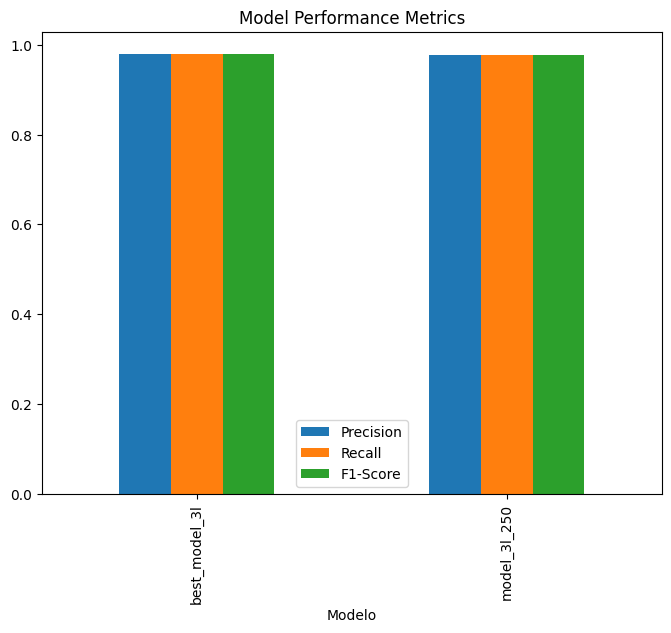

In [12]:
results_3L_df.set_index("Modelo").plot(kind="bar", figsize=(8, 6), title="Model Performance Metrics")


Tras esta comparacón de modelos, vemos que el modelo con capas de 300 neuronas rinde mejor en todas las métricas. Vamos a evaluarlo en el conjunto de pruebas para ver realmente como de exacto es.

In [40]:
test_loss, test_accuracy = best_model_3l.evaluate(X_test, y_test)
print(f"Pérdida del mejor modelo de 3 capas: {test_loss}")
print(f"Exactitud del mejor modelo de 3 capas: {test_accuracy}")


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9745 - loss: 0.0944
Pérdida del mejor modelo de 3 capas: 0.07852483540773392
Exactitud del mejor modelo de 3 capas: 0.9787999987602234


Vemos que la exactitud es muy buena, casi de un 98%. Vamos a intentar ajustar el learning rate para superar el 98%.

#### Ajustando el learning rate

Ahora que tenemos el mejor modelo de 3 capas. Vamos a intentar superar el 98% de Exactitud ajustando el learning rate. Construimos el modelo desde el principio, para que no se vea afectado por el entrenamiento anterior. Usamos el array best_layers para no tener que indicar el número de neuronas por capa manualmente.

In [55]:
tf.keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

model = tf.keras.Sequential([
        tf.keras.Input(shape=(28, 28)),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(best_layers, activation="relu"),
        tf.keras.layers.Dense(best_layers, activation="relu"),
        tf.keras.layers.Dense(best_layers, activation="relu"),
        tf.keras.layers.Dense(10, activation="softmax")
    ])

optimizer = tf.keras.optimizers.SGD(learning_rate=1e-2)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])
expon_lr = ExponentialLearningRate(factor=1.005)

In [56]:
history = model.fit(X_train, y_train, epochs=1,
                    validation_data=(X_valid, y_valid),
                    callbacks=[expon_lr])

1719/1719 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.6137 - loss: nan - val_accuracy: 0.0958 - val_loss: nan


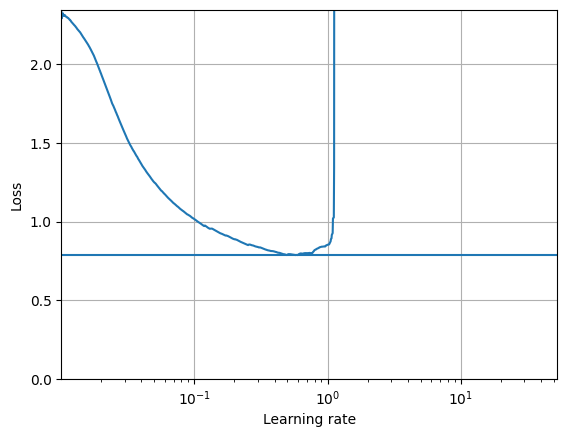

In [57]:
plt.plot(expon_lr.rates, expon_lr.losses)
plt.gca().set_xscale('log')
plt.hlines(min(expon_lr.losses), min(expon_lr.rates), max(expon_lr.rates))
plt.axis([min(expon_lr.rates), max(expon_lr.rates), 0, expon_lr.losses[0]])
plt.grid()
plt.xlabel("Learning rate")
plt.ylabel("Loss")
plt.show()


En la grafica anterior vemos que la pérdida explota cuando el learning rate supera el valor de 1. Por recomendación del libro, vamos a tomar como learning rate una cantidad 10 veces menor, es decir, 0.1.

Limpiamos la sesión y reentrenamos el modelo con el nuevo learning rate.

In [58]:
tf.keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

model = tf.keras.Sequential([
        tf.keras.Input(shape=(28, 28)),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(best_layers, activation="relu"),
        tf.keras.layers.Dense(best_layers , activation="relu"),
        tf.keras.layers.Dense(best_layers , activation="relu"),
        tf.keras.layers.Dense(10, activation="softmax")
    ])

In [59]:
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-1)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])

Preparamos una carpeta para guardar los datos de tensorboard.

In [60]:
from pathlib import Path

run_index = 2
run_logdir = Path() / "my_mnist_logs_customLR" / "run_{:03d}".format(run_index)
run_logdir

WindowsPath('my_mnist_logs_customLR/run_002')

Entrenamos el modelo con los callbacks usuales: Early stopping, model checkpoint y tensorboard

In [61]:
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=20)
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("3l_LR.keras", save_best_only=True)
tensorboard_cb = tf.keras.callbacks.TensorBoard(run_logdir)

history = model.fit(X_train, y_train, epochs=100,
                    validation_data=(X_valid, y_valid),
                    callbacks=[checkpoint_cb, early_stopping_cb, tensorboard_cb])

Epoch 1/100
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.8454 - loss: 0.4912 - val_accuracy: 0.9638 - val_loss: 0.1161
Epoch 2/100
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9655 - loss: 0.1132 - val_accuracy: 0.9708 - val_loss: 0.0975
Epoch 3/100
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9786 - loss: 0.0709 - val_accuracy: 0.9734 - val_loss: 0.0880
Epoch 4/100
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9864 - loss: 0.0480 - val_accuracy: 0.9766 - val_loss: 0.0808
Epoch 5/100
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9903 - loss: 0.0333 - val_accuracy: 0.9722 - val_loss: 0.1002
Epoch 6/100
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9926 - loss: 0.0258 - val_accuracy: 0.9770 - val_loss: 0.0916
Epoch 7/100
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9936 - loss: 0.0212 - val_accuracy: 0.9786 - val_loss: 0.0863
Epoch 8/100
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9952 - loss: 0

Vemos que ajustar el learning rate ha sido efectivo y hemos superado el 98% de exactitud en el conjunto de pruebas.

In [52]:
model = tf.keras.models.load_model("3l_LR.keras")
test_loss, test_accuracy = model.evaluate(X_test, y_test)

print(f"Pérdida del mejor modelo de 3 capas con learning rate ajustado: {test_loss}")
print(f"Exactitud del mejor modelo de 3 capas learning rate ajustado: {test_accuracy}")

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9762 - loss: 0.0955
Pérdida del mejor modelo de 3 capas con learning rate ajustado: 0.07836354523897171
Exactitud del mejor modelo de 3 capas learning rate ajustado: 0.9807999730110168


### Modelo de 4 capas.

Pasamos ahora a los de 4 capas. Vamos construir modelos de 4 capas con  250, 300, 350 o 400 neuronas. Para cada uno de los modelos, comenzamos limpiando la sesión e inicializando las semillas aleatorias. Puesto que no estamos entrenando demasiados modelos no es estrictamente necesario hacer esto antes de entrenar cada modelo, pero ayuda puesto que TensorFlow almacena los datos de los modelos y sus grafos de computación en una sesión global. En cada interación del bucle creamos una carpeta donde guardar los datos para visualizar luego con tensorboard y guardamos el mejor modelo y los resultados.

El código de la siguente celda hace lo siguiente:

    - Elegimos un array de posibles tamaños de las capas, en este caso, 250, 300, 350, 400.
    - Para cada uno de los tamaños entrenamos un modelo de cuatro capas ocultas usando early stopping, model checkpoint y tensorboard, además guardamos los datos del modelo en un diccionario.
    - Una vez hemos probado todas los modelos extraemos el modelo con los mejores resultados usando los datos del diccionario. 

In [80]:

# Configuramos early stopping
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=20)

# Posibles tamaños de capa
hidden_layer_sizes = [250, 300, 350, 400]

# Diccionario para los resultados
results = []

# Probamos todas las posibles combinaciones
for h in hidden_layer_sizes:
    optimizer = tf.keras.optimizers.SGD(learning_rate=3e-1)


    tf.keras.backend.clear_session()
    np.random.seed(42)
    tf.random.set_seed(42)

    print(f"Entrenando modelo con {h} neuronas:")

        # Creamos un directorio para cada configuración
    unique_run_logdir = Path() / "my_mnist_logs_4L" / f"4L_{h}"
    unique_run_logdir.mkdir(parents=True, exist_ok=True)
    tensorboard_cb = tf.keras.callbacks.TensorBoard(str(unique_run_logdir))

    checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
    f"Best_model_4L_{h}.keras", save_best_only=True
)
    
    # Creamos el modelo
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(28, 28)),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(h, activation="relu"),
        tf.keras.layers.Dense(h, activation="relu"),
        tf.keras.layers.Dense(h, activation="relu"),
        tf.keras.layers.Dense(h, activation="relu"),
        tf.keras.layers.Dense(10, activation="softmax")
    ])
    
    model.compile(optimizer=optimizer,
                  loss="sparse_categorical_crossentropy",
                  metrics=["accuracy"])
    
    # Entrenamos el modelo
    history = model.fit(
        X_train, y_train,
        epochs=100,
        validation_data=(X_valid, y_valid),
        callbacks=[checkpoint_cb, early_stopping_cb, tensorboard_cb],
        verbose=0  
    )
    
    # Evaluamos en el conjunto de validación
    val_loss, val_acc = model.evaluate(X_valid, y_valid, verbose=0)
    print(f"Validation loss: {val_loss}, Validation accuracy: {val_acc}")
    
    # Guardamos resultados
    results.append({
        "neurons": h,
        "val_loss": val_loss,
        "val_acc": val_acc
    })

# Buscamos el mejor modelo
results_4L_df = pd.DataFrame(results)
best_model_4layers = results_4L_df.loc[results_4L_df["val_acc"].idxmax()]
print("\nMejor modelo 4 capas:")
print(best_model_4layers)

# Guardamos los datos en un csv
results_4L_df.to_csv("model_results_4layers_summary.csv", index=False)
print("Resultados guardados en 'model_results_4layers_summary.csv'")

Entrenando modelo con 250 neuronas:
Validation loss: 0.1094718649983406, Validation accuracy: 0.9828000068664551
Entrenando modelo con 300 neuronas:
Validation loss: 0.1103324219584465, Validation accuracy: 0.9836000204086304
Entrenando modelo con 350 neuronas:
Validation loss: 0.09599965810775757, Validation accuracy: 0.9846000075340271
Entrenando modelo con 400 neuronas:
Validation loss: 0.11850909143686295, Validation accuracy: 0.9807999730110168

Mejor modelo 4 capas:
neurons     350.0000
val_loss      0.0960
val_acc       0.9846
Name: 2, dtype: float64
Resultados guardados en 'model_results_4layers_summary.csv'


Podemos ver los datos del mejor modelo y las curvas de aprendizaje en tensorboard.

Nótese que debido a que usamos early stopping, las curvas nunca se vuelven demasiado planas (puesto que early stopping para el entrenamiento en ese caso) y que cada modelo tiene curvas de longitud diferente, de nuevo debido al early stopping.

In [81]:
best_model_4layers

neurons     350.0000
val_loss      0.0960
val_acc       0.9846
Name: 2, dtype: float64

In [19]:

%tensorboard --logdir=./my_mnist_logs_4L

Reusing TensorBoard on port 6008 (pid 22544), started 0:00:12 ago. (Use '!kill 22544' to kill it.)

In [ ]:
# Extraemos la mejor configuración de las capas
best_layers = best_model_4layers['neurons'].astype(int)

# Construimos el nombre del archivo
best_4lmodel_filename = f"Best_model_4L_{best_layers}.keras"

# Cargamos el mejor modelo
print(f"Cargando el modelo {best_4lmodel_filename}") #
best_model_4l = tf.keras.models.load_model(best_4lmodel_filename)


Cargando el modelo Best_model_4L_350.keras


También podemos cargar el modelo manualmente. Vamos a usar más métricas para comparar el modelo de 350 neuronas (que hemos encontrado como mejor) y el de 250 neuronas.

In [10]:
best_model_4l = tf.keras.models.load_model("Best_model_4L_350.keras")
model_4l_250= tf.keras.models.load_model("Best_model_4L_250.keras")


Vamos a usar el conjunto de validación para calcular ciertas métricas. Para ello necesitamos un vector de predicciones, usamos argmax para identificar la clase con más probabilidad.

De nuevo usamos la precisión, sensitividad y el F1 para comparar los modelos. Estamos usando average=macro que computa el promedio no ponderado de la precisión/recall/F1 para cada clase.

In [43]:
y_pred_probs_350 = best_model_4l.predict(X_valid)
y_pred_350 = np.argmax(y_pred_probs_300, axis=1)

precision_350 = precision_score(y_valid, y_pred_350, average='macro')
recall_350 = recall_score(y_valid, y_pred_350, average='macro')
f1_350 = f1_score(y_valid, y_pred_350, average='macro')

y_pred_probs_250 = model_4l_250.predict(X_valid)
y_pred_250 = np.argmax(y_pred_probs_250, axis=1)

precision_250 = precision_score(y_valid, y_pred_250, average='macro')
recall_250 = recall_score(y_valid, y_pred_250, average='macro')
f1_250 = f1_score(y_valid, y_pred_250, average='macro')

results = {
    "Modelo": ["best_model_4l", "model_4l_250"],
    "Precision": [precision_350, precision_250],
    "Recall": [recall_350, recall_250],
    "F1-Score": [f1_350, f1_250]
}

# Lo convertimos en dataframe
results_4L_df = pd.DataFrame(results)

results_4L_df



157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


,Modelo,Precision,Recall,F1-Score
0,best_model_4l,0.980139,0.979888,0.979978
1,model_4l_250,0.977071,0.976505,0.976734


Tras esta comparacón de modelos, vemos que el modelo con capas de 350 neuronas rinde mejor en todas las métricas. Vamos a evaluarlo en el conjunto de pruebas para ver realmente como de exacto es.

In [44]:
test_loss, test_accuracy = best_model_4l.evaluate(X_test, y_test)
print(f"Pérdida del mejor modelo de 4 capas: {test_loss}")
print(f"Exactitud del mejor modelo de 4 capas: {test_accuracy}")

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9734 - loss: 0.1009
Pérdida del mejor modelo de 4 capas: 0.08270996063947678
Exactitud del mejor modelo de 4 capas: 0.9779999852180481


De nuevo obtenemos una exactitud muy alta, vamos a intentar mejorarla.

#### Ajustando el learning rate

Ahora que tenemos el mejor modelo de 4 capas. Vamos a intentar superar el 98% de exactitud ajustando el learning rate. Construimos el modelo desde el principio, para que no se vea afectado por el entrenamiento anterior. Usamos el array best_layers para no tener que indicar el número de neuronas por capa manualmente.

In [49]:
tf.keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

model = tf.keras.Sequential([
        tf.keras.Input(shape=(28, 28)),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(best_layers, activation="relu"),
        tf.keras.layers.Dense(best_layers, activation="relu"),
        tf.keras.layers.Dense(best_layers, activation="relu"),
        tf.keras.layers.Dense(best_layers, activation="relu"),
        tf.keras.layers.Dense(10, activation="softmax")
    ])

optimizer = tf.keras.optimizers.SGD(learning_rate=1e-2)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])
expon_lr = ExponentialLearningRate(factor=1.005)

In [50]:
history = model.fit(X_train, y_train, epochs=1,
                    validation_data=(X_valid, y_valid),
                    callbacks=[expon_lr])

1719/1719 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.5814 - loss: nan - val_accuracy: 0.0958 - val_loss: nan


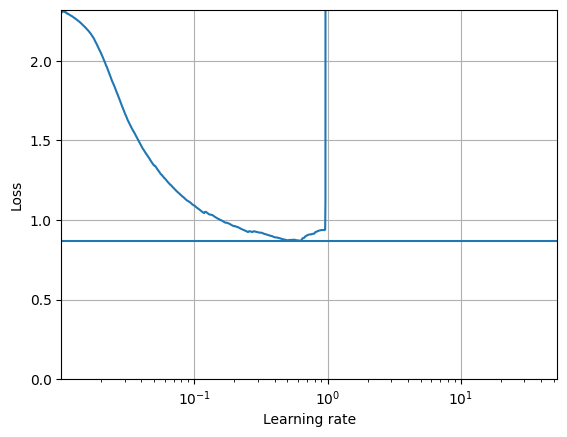

In [51]:
plt.plot(expon_lr.rates, expon_lr.losses)
plt.gca().set_xscale('log')
plt.hlines(min(expon_lr.losses), min(expon_lr.rates), max(expon_lr.rates))
plt.axis([min(expon_lr.rates), max(expon_lr.rates), 0, expon_lr.losses[0]])
plt.grid()
plt.xlabel("Learning rate")
plt.ylabel("Loss")
plt.show()


En la grafica anterior vemos que la pérdida explota cuando el learning rate se aproxima al valor de 1. Por recomendación del libro, vamos a tomar como learning rate una cantidad 10 veces menor, es decir, 0.1.

Limpiamos la sesión y reentrenamos el modelo con el nuevo learning rate.

In [87]:
tf.keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

model = tf.keras.Sequential([
        tf.keras.Input(shape=(28, 28)),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(best_layers, activation="relu"),
        tf.keras.layers.Dense(best_layers, activation="relu"),
        tf.keras.layers.Dense(best_layers, activation="relu"),
        tf.keras.layers.Dense(best_layers, activation="relu"),
        tf.keras.layers.Dense(10, activation="softmax")
    ])

In [88]:
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-1)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])

Creamos una carpeta para guardar los datos de tensorboard.

In [89]:
from pathlib import Path

run_index = 3
run_logdir = Path() / "my_mnist_logs_customLR" / "run_{:03d}".format(run_index)
run_logdir

WindowsPath('my_mnist_logs_customLR/run_003')

Entrenamos el modelo con los callbacks usuales: Early stopping, model checkpoint y tensorboard

In [90]:
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=20)
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("4l_LR.keras", save_best_only=True)
tensorboard_cb = tf.keras.callbacks.TensorBoard(run_logdir)

history = model.fit(X_train, y_train, epochs=100,
                    validation_data=(X_valid, y_valid),
                    callbacks=[checkpoint_cb, early_stopping_cb, tensorboard_cb])

Epoch 1/100
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.8340 - loss: 0.5294 - val_accuracy: 0.9694 - val_loss: 0.1078
Epoch 2/100
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9660 - loss: 0.1105 - val_accuracy: 0.9762 - val_loss: 0.0831
Epoch 3/100
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9805 - loss: 0.0658 - val_accuracy: 0.9752 - val_loss: 0.0880
Epoch 4/100
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9870 - loss: 0.0439 - val_accuracy: 0.9788 - val_loss: 0.0829
Epoch 5/100
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.9900 - loss: 0.0329 - val_accuracy: 0.9714 - val_loss: 0.1095
Epoch 6/100
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9913 - loss: 0.0287 - val_accuracy: 0.9792 - val_loss: 0.0807
Epoch 7/100
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9943 - loss: 0.0196 - val_accuracy: 0.9786 - val_loss: 0.0893
Epoch 8/100
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9949 - loss: 0

¡Hemos mejorado considerablemente la exactitud, llegando casi a un 98.5!

In [55]:
model = tf.keras.models.load_model("4l_LR.keras")
test_loss, test_accuracy = model.evaluate(X_test, y_test)


print(f"Pérdida del mejor modelo de 4 capas con learning rate ajustado: {test_loss}")
print(f"Exactitud del mejor modelo de 4 capas learning rate ajustado: {test_accuracy}")

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9822 - loss: 0.0895
Pérdida del mejor modelo de 4 capas con learning rate ajustado: 0.07346057146787643
Exactitud del mejor modelo de 4 capas learning rate ajustado: 0.9847000241279602


# 4 Conclusiones


En esta actividad, se abordó el problema de entrenamiento de redes neuronales para clasificar el dataset MNIST con el objetivo de alcanzar una exactitud del 98%. Se entrenaron modelos con 3 y 4 capas ocultas, utilizando diferentes configuraciones de hiperparámetros y ajustando elementos clave como el número de neuronas y la tasa de aprendizaje.

Los principales hallazgos se pueden resumir en los siguientes puntos.

Entrenamos modelos de 3 y 4 capas ocultas de 250, 300, 350 y 400 neuronas por capa. Decidimos probar estos modelos puesto que en el libro de la asignatura se comenta que hoy día en la práctica lo mejor es usar un número uniforme de neuronas por capa (para reducir hiperparámetros que ajustar) y emplear tecnicas de regularización y early stopping para evitar el sobreajuste.

En cuanto a los resultados de los modelos, se observó que los modelos con 3 capas y 300 neuronas lograron un mejor desempeño en validación en comparación con sus contrapartes con 250, 350 y 400 neuronas. Por otro lado, entre los modelos con 4 capas, el modelo con 350 neuronas obtuvo la mejor exactitud tanto en validación como en pruebas. Esto confirma que un mayor número de neuronas en capas adicionales puede mejorar la capacidad de generalización, aunque con mayores requerimientos computacionales.

Sobre el impacto del ajuste de hiperparámetros, los modelos optimizados con tasas de aprendizaje personalizadas mostraron mejoras notables en su desempeño. Esto destaca la importancia de este hiperparámetro en el entrenamiento eficiente.

Finalmente, se obtuvieron importantes lecciones aprendidas. La estructura y configuración del modelo afectan significativamente el desempeño, por lo que balancear profundidad y tamaño de capas es crucial para encontrar un equilibrio entre exactitud y complejidad. Además, el monitoreo constante del desempeño en los conjuntos de validación y pruebas resulta esencial para evitar resultados optimistas no generalizables.



Recordemos que entrenamos todos nuestro modelos con early stopping para que el entrenamiento parara cuando no se hacía mucho progresso mejorando la perdida en el conjunto de entrenamiento. Esto es una medida para evitar el sobreajuste que además tiene la ventaja de que puede aligerar mucho el proceso de entrenamiento puesto que en este caso la mayoría de modelos entrenaba menos de 40 epocas en vez de 100 tal y como le habíamos pedido.

Puesto que al entrenar los modelos guardamos los datos en un csv podemos visualizarlos de nuevo fácilmente cargando los archivos.

In [47]:
all_results_4L = pd.read_csv("model_results_4layers_summary.csv")
all_results_3L = pd.read_csv("model_results_3layers_summary.csv")


Para los modelos de 3 capas:

In [48]:
all_results_3L

,neurons,val_loss,val_acc
0,250,0.112329,0.9828
1,300,0.107291,0.9838
2,350,0.111514,0.9802
3,400,0.109694,0.9830


Para los de 4:

In [49]:
all_results_4L

,neurons,val_loss,val_acc
0,250,0.109472,0.9828
1,300,0.110332,0.9836
2,350,0.096000,0.9846
3,400,0.118509,0.9808


Usando la exactitud como métrica concluimos que el mejor modelo de 3 capas era aquel con 300 neuronas por capa y el mejor modelo de 4 capas era el de 350 neuronas por capa. Además, usamos métricas extra para comparar el mejor modelo con el de 250 neuronas (en 3 y 4 capas)


Para 3 capas ocultas:

In [51]:
results_3L_df

,Modelo,Precision,Recall,F1-Score
0,best_model_3l,0.980139,0.979888,0.979978
1,model_3l_250,0.978544,0.977984,0.978234


Para 4 capas:

In [52]:
results_4L_df

,Modelo,Precision,Recall,F1-Score
0,best_model_4l,0.980139,0.979888,0.979978
1,model_4l_250,0.977071,0.976505,0.976734


Limpiamos la sesión y cargando los modelos pertinentes.

In [50]:
tf.keras.backend.clear_session()

best_model_3l = tf.keras.models.load_model("Best_model_3L_300.keras")
model_3l_250= tf.keras.models.load_model("Best_model_3L_250.keras")
Best_model_3l_customLR = tf.keras.models.load_model("3l_LR.keras")

best_model_4l = tf.keras.models.load_model("Best_model_4L_350.keras")
model_4l_250= tf.keras.models.load_model("Best_model_4L_250.keras")
Best_model_4l_customLR = tf.keras.models.load_model("4l_LR.keras")

Tenemos 6 modelos cargados. 

Tres de ellos son de 3 capas: tenemos el modelo de 3 capas con 250 neuronas, el de 3 capas de 300 neuronas (que es el que mejor exactitud tenia en el conjunto de validación) que fueron entrenados con el learning rate de github y luego el modelo con capas de 300 neuronas para el que ajustamos el learning rate.

Tres de ellos son de 3 capas: tenemos el modelo de 4 capas con 250 neuronas, el de 4 capas de 350 neuronas (que es el que mejor exactitud tenia en el conjunto de validación) que fueron entrenados con el learning rate de github y luego el modelo con capas de 350 neuronas para el que ajustamos el learning rate.

Tras esto ajustamos el learning rate para el mejor modelo de 3 y 4 capas ocultas usando la misma técnica: Incrementamos el learning rate exponencialmente hasta que veiamos que el error explotaba y luego seleccionabamos ese valor dividido entre 10. Curiosamente, el valor óptimo para el learning rate coincidía para los dos modelos.

Otra opción sería haber usado Keras tuner para ajustar este hiperparámetro pero hemos decidido hacerlo "manualmente" puesto que es más ilustrativo.

A continuación mostramos el desempeño de todos los modelos cargados en el conjunto de validación y de pruebas:

In [7]:
#Creamos un diccionario con los modelos
models = {
    "Best_model_3L_250": model_3l_250,
    "Best_model_3L_300": best_model_3l,
    "3L_Custom_LR": Best_model_3l_customLR,
    "Best_model_4L_250": model_4l_250,
    "Best_model_4L_350": best_model_4l,
    "4L_Custom_LR": Best_model_4l_customLR
}

# Inicializamos unas listas para guardar los resultados
model_names = []
validation_loss = []
validation_accuracy = []
test_loss = []
test_accuracy = []

# Evaluamos los modelos
for name, model in models.items():
    # En el conjunto de validación
    val_loss, val_accuracy = model.evaluate(X_valid, y_valid, verbose=0)
    
    # En el conjunto de pruebas
    test_loss_val, test_accuracy_val = model.evaluate(X_test, y_test, verbose=0)
    
    # Almacenamos los resultados
    model_names.append(name)
    validation_loss.append(val_loss)
    validation_accuracy.append(val_accuracy)
    test_loss.append(test_loss_val)
    test_accuracy.append(test_accuracy_val)

# Creamos un dataframe con los datos
results_df = pd.DataFrame({
    "Model": model_names,
    "Validation Loss": validation_loss,
    "Validation Accuracy": validation_accuracy,
    "Test Loss": test_loss,
    "Test Accuracy": test_accuracy
})

results_df


,Model,Validation Loss,Validation Accuracy,Test Loss,Test Accuracy
0,Best_model_3L_250,0.083097,0.9784,0.076098,0.9785
1,Best_model_3L_300,0.080455,0.9802,0.078525,0.9788
2,3L_Custom_LR,0.080679,0.9804,0.078364,0.9808
3,Best_model_4L_250,0.083968,0.9770,0.082688,0.9763
4,Best_model_4L_350,0.078197,0.9792,0.082710,0.9780
5,4L_Custom_LR,0.080670,0.9838,0.073461,0.9847


Se observa que los modelos con 3 capas y 300 neuronas logran un mejor desempeño en validación (98.02%) en comparación con sus contrapartes con 250 neuronas (97.84%). Por otro lado, entre los modelos con 4 capas, el modelo con 350 neuronas obtiene la mejor exactitud tanto en validación (97.92%) como en pruebas (97.80%). Esto confirma que un mayor número de neuronas en capas adicionales mejora la capacidad de generalización, aunque con mayores requerimientos computacionales. Cabe destacar que el modelo optimizado manualmente con 4 capas ("4L_Custom_LR") logra el mejor resultado global con una exactitud de prueba del 98.47% y que el modelo optmizado manualmente con 3 capas ("3L_Custom_LR") logra el mejor resultado entre los modelos de 3 capas ocultas.


Vamos a observar con más detalle las curvas de aprendizaje de los dos modelos con el learning rate ajustado.

In [31]:
%tensorboard --logdir=./my_mnist_logs_customLR/

Reusing TensorBoard on port 6012 (pid 1464), started 0:00:02 ago. (Use '!kill 1464' to kill it.)

Vemos que el modelo de 4 capas ocultas toma más épocas (y más tiempo) en completar el ajuste, pero a cambio desempeña considerablemente mejor sobre el conjunto de validación.

A veces nos ocurre que cuando vemos números escritos que son similares en la calígrafia de ciertas personas (por ejemplo un 7 y un 1) no sabemos diferenciarlos demasiado bien. Vamos a mirar si nuestros mejores modelos sufren las mismas confusiones que los humanos (1 y 7/ 9 y 4) o si su forma de entender los números es diferente y por tanto comete otros errores.

157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


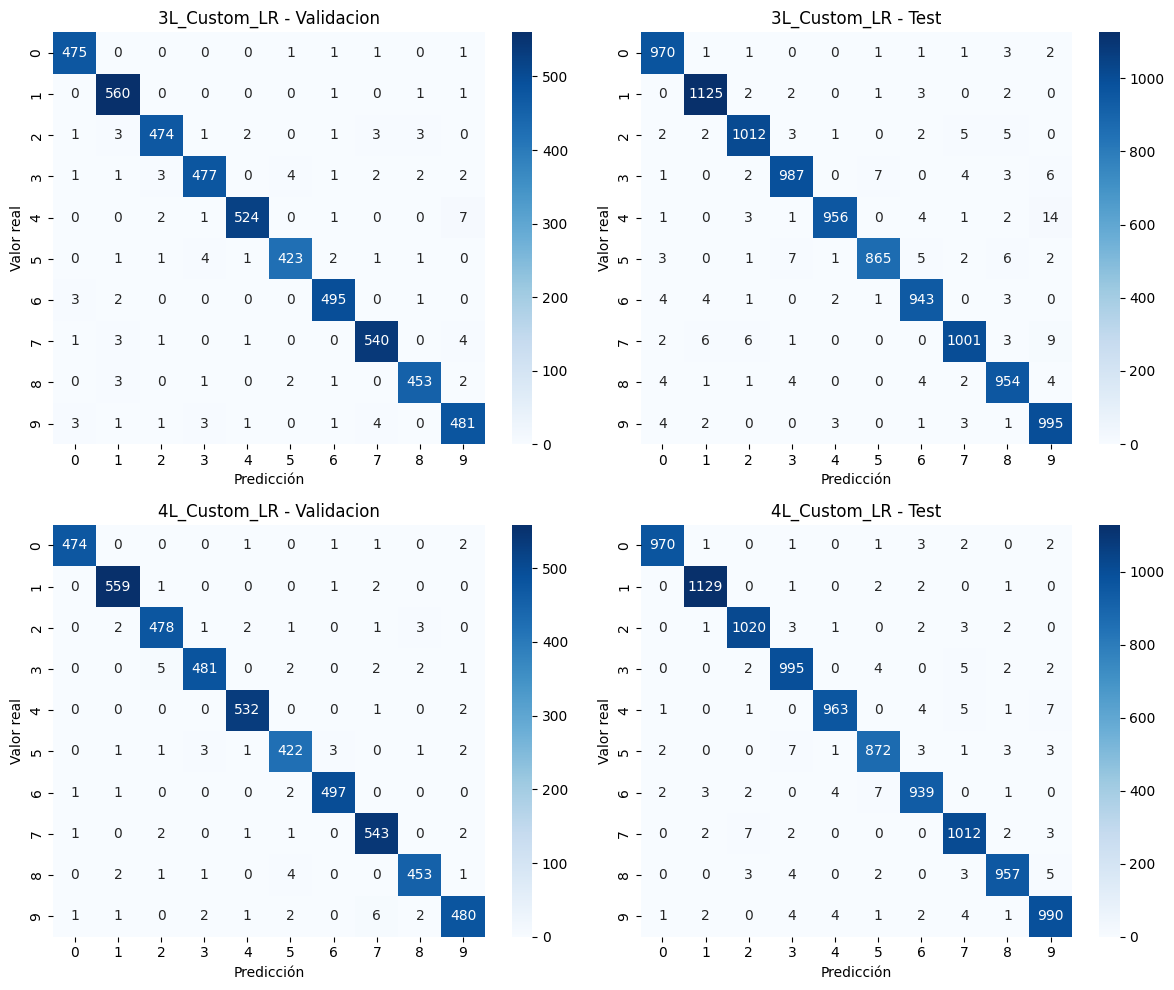

In [39]:
import seaborn as sns
from sklearn.metrics import confusion_matrix


def plot_heatmap(ax, model, X, y, dataset_name, model_name):
    # Hacemos las predicciones
    y_pred = np.argmax(model.predict(X), axis=1)
    
    # Matriz de confusión y mapa de calor
    cm = confusion_matrix(y, y_pred)

    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=range(10), yticklabels=range(10), ax=ax)
    ax.set_title(f"{model_name} - {dataset_name}")
    ax.set_xlabel("Predicción")
    ax.set_ylabel("Valor real")

# Creamos los subplots
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Mapas de calor 3L_Custom_LR
plot_heatmap(axes[0, 0], Best_model_3l_customLR, X_valid, y_valid, "Validacion", "3L_Custom_LR")
plot_heatmap(axes[0, 1], Best_model_3l_customLR, X_test, y_test, "Test", "3L_Custom_LR")

# Mapas de calor 4L_Custom_LR
plot_heatmap(axes[1, 0], Best_model_4l_customLR, X_valid, y_valid, "Validacion", "4L_Custom_LR")
plot_heatmap(axes[1, 1], Best_model_4l_customLR, X_test, y_test, "Test", "4L_Custom_LR")

# Layout
plt.tight_layout()
plt.show()

Es muy curioso que aunque parece que sí que tiene problemas en diferenciar 9 y 4, el número 7 lo confunden más con el número 2 que con el número 1. Este tipo de confusión es algo no muy común entre las personas y sería interesante intentar averiguar que estructuras encuentran similares entre estos dos números.

## Líneas de investigación futura

Para futuros trabajos, se podrían explorar arquitecturas más avanzadas como redes neuronales convolucionales (CNN), que son particularmente efectivas para tareas de clasificación de imágenes. Investigar el impacto de agregar capas de dropout o batch normalization podría mejorar la regularización y la estabilidad del entrenamiento. Otra línea interesante sería realizar una optimización más exhaustiva de los hiperparámetros, utilizando técnicas como grid search, random search o enfoques más avanzados como optimización bayesiana.

También sería valioso analizar el desempeño de los modelos al aplicar transferencia de aprendizaje, utilizando modelos preentrenados en conjuntos de datos más complejos como CIFAR-10 o ImageNet, y adaptándolos para clasificar MNIST u otros datasets similares. Esto permitiría evaluar si las mejoras obtenidas en este trabajo son aplicables a problemas más complejos o a datos del mundo real.

Otro aspecto clave es la eficiencia y escalabilidad. Reducir la dimensionalidad de los datos mediante PCA o autoencoders antes del entrenamiento podría reducir el costo computacional. Además, investigar las predicciones erróneas mediante el análisis de sensibilidad o visualización de activaciones podría ayudar a identificar limitaciones del modelo y áreas específicas de mejora.

Finalmente, sería interesante extender este análisis a otros conjuntos de datos similares, como Fashion-MNIST, para evaluar la generalización del enfoque. También podría explorarse la transferencia de los hallazgos a tareas relacionadas como detección de objetos o segmentación de imágenes.